In [498]:
from pymongo import MongoClient
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import scipy.optimize

client = MongoClient("c3.itp.ac.ru", 27027)

In [460]:
def corr_time(Nx, Ny, T, min_time = 0, max_time = np.inf, draw_each = False, fit=False):
    mt = []
    df = pd.DataFrame()
    for result in client.numerics.glass.find({"Nx": Nx, "Ny": Ny, "T": T}):
       #  if np.abs(result['corr_values'][-1]) >= 1e-2: continue
        # flag = False
        # for el in result['corr_values']:
        #    if el < 0:
        #         flag = True
        #         break
        # if flag:
        #     continue
            
        x = np.array(result['corr_times'])
        y = np.array(result['corr_values'])
        
        y = y[(x[:] >= min_time) & (x[:] <= max_time)]
        x = x[(x[:] >= min_time) & (x[:] <= max_time)]

        if draw_each:
            plt.semilogy(x, y)
            
        df = pd.concat([df, pd.Series(y)], axis=1)
        
    y_mean = df.mean(axis=1)
    y_err = df.std(axis=1)
    
    
    plt.errorbar(x, y_mean, yerr=y_err, linestyle='-.', label="Temp: {}".format(T), elinewidth=0.5, errorevery=2)
    plt.yscale('log')
    #plt.semilogy(x, y_mean, linestyle='-.', label="Temp: {}".format(T))
    
    plt.legend()
    
    if fit:
        params, params_covariance = scipy.optimize.curve_fit(q_line, x, np.log(np.array(y_mean)))
        plt.semilogy(x, q(x, params[0], params[1]), linestyle='--')
                
        print(params)

In [164]:
def q_line(t, tau, A):
    return A - t / tau

In [439]:
def q_beta(t, tau, A, beta):
    return A - t ** beta / tau

In [165]:
def q(t, tau, A):
    return np.exp(A - t / tau)

In [166]:
def observables(Nx, Ny, T):
    e, m, chi, c = [], [], [], []
    for result in client.numerics.ising.find({"Nx": Nx, "Ny": Ny, "T": T}):
       #  if np.abs(result['corr_values'][-1]) >= 1e-2: continue
        e.append(result['Energy'])
        m.append(np.abs(result['Magnetization']))
        c.append(result['Energy2'])
        chi.append(result['Magnetization2'])
    return [np.mean(e), np.mean(m), np.mean(c), np.mean(chi)]

Text(0, 0.5, '<q(t)>')

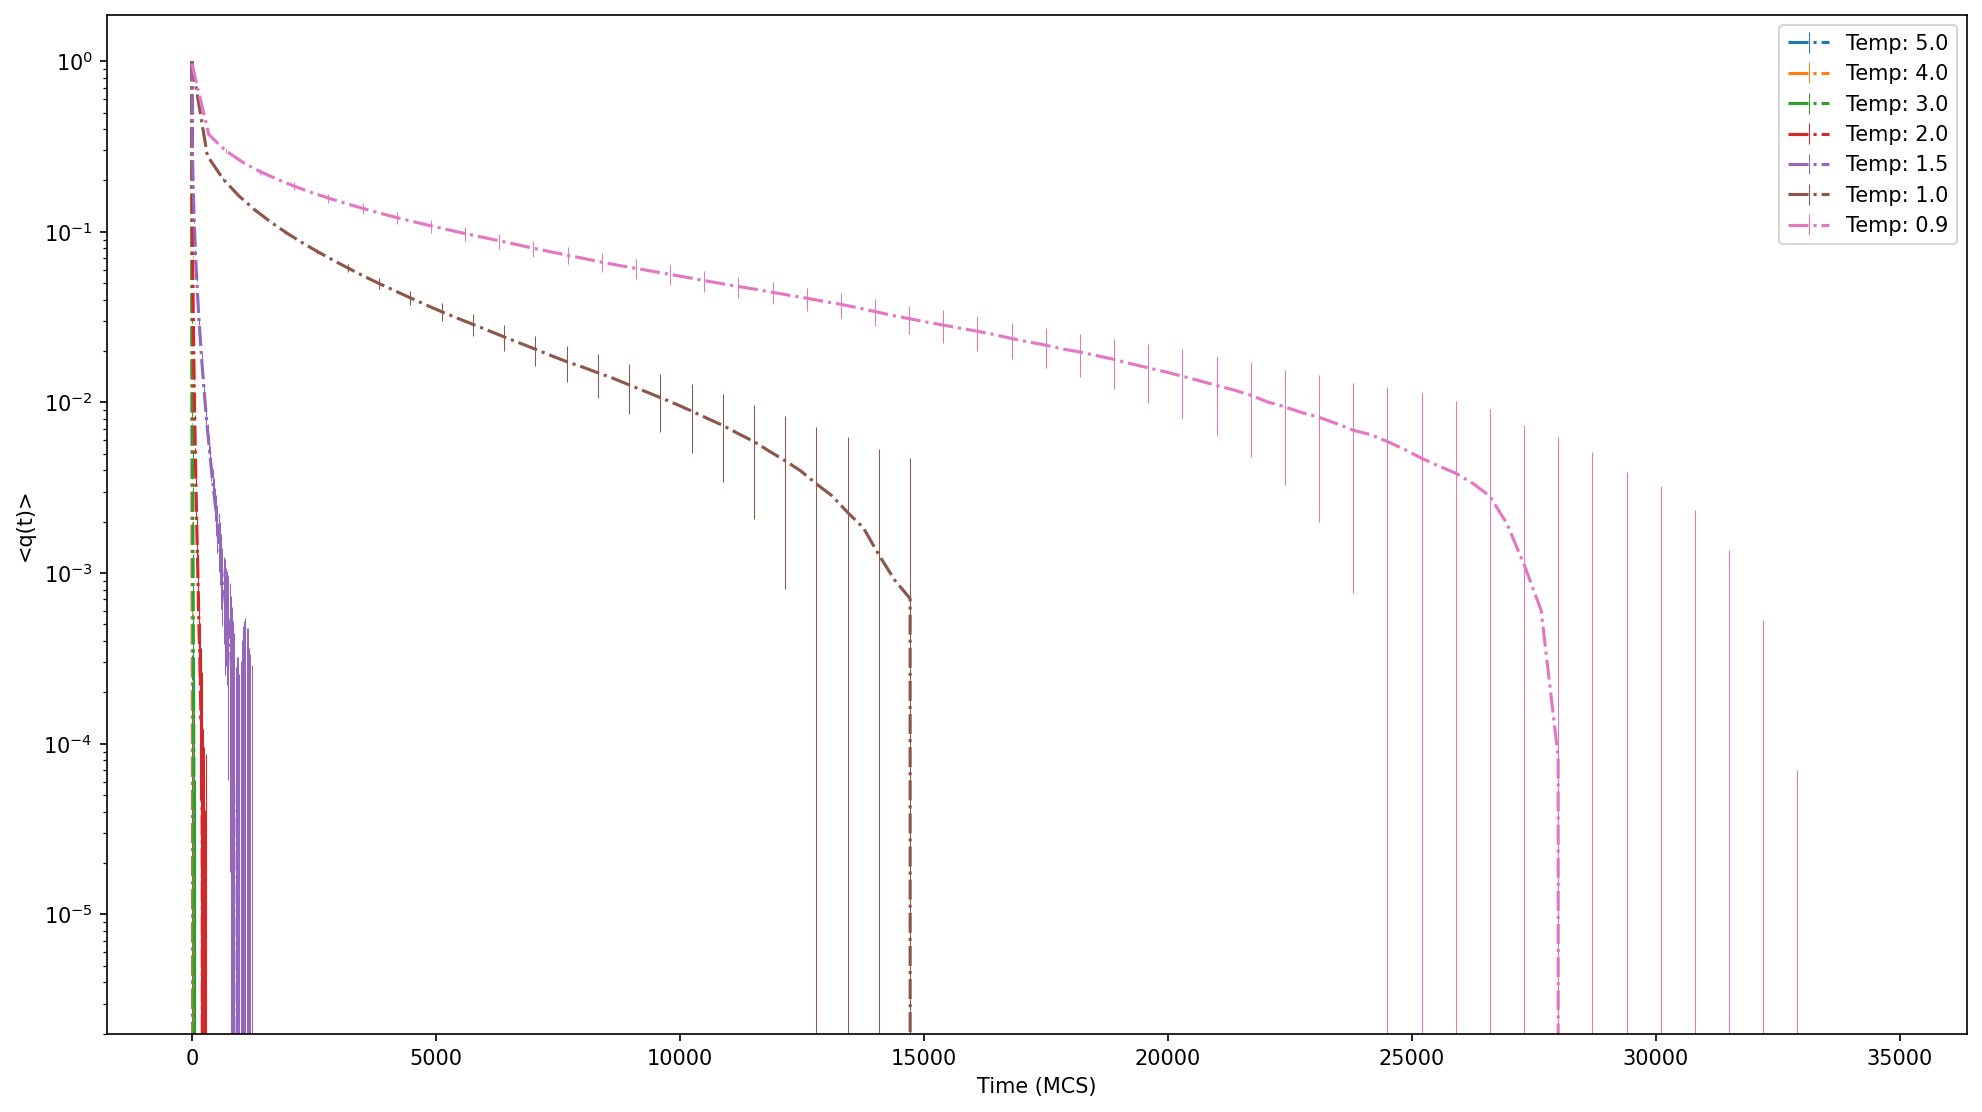

In [508]:
plt.figure(figsize=(16, 9), dpi=150)

corr_time(100, 100, 5.0)
corr_time(100, 100, 4.0)
corr_time(100, 100, 3.0)
corr_time(100, 100, 2.0)
corr_time(100, 100, 1.5)
corr_time(100, 100, 1.0)
corr_time(100, 100, 0.9)
plt.xlabel('Time (MCS)')
plt.ylabel('<q(t)>')

# plt.xlim(0, 40)

### ferromagnetic 

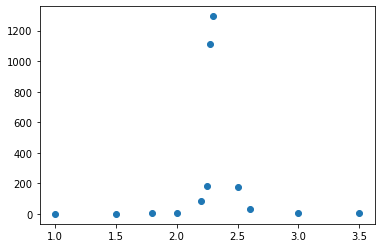

In [358]:
temp = np.array([1, 1.5, 1.8, 2, 2.2, 2.25, 2.27, 2.3, 2.5, 2.6, 3, 3.5])
tau = np.array([0.99824405, 1.24013707, 3.87455095, 8.88365412, 83.95509624, 184.0874894, 1112.24625119, 1293.45461192, 176.15564308, 34.62297555, 8.54602628, 4.09455078])

plt.scatter(temp, tau)

temps = [1, 1.5, 1.8, 2, 2.2, 2.25, 2.3, 2.6, 3, 3.5]
char_df = pd.DataFrame()
for i in temps:
    char_df = pd.concat([char_df, pd.Series(observables(100, 100, i))], axis=1)
    
char_df.columns = temps
char_df = char_df.T
char_df.columns = ['E', 'M', 'C', 'Chi']